# Variational Auto-Encoder


In [1]:
import pickle
import petname
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as fcnl
import torch.optim as optim
import torch.utils.data as data
import torch.utils.tensorboard as tensorboard
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
%matplotlib inline

### Dataset and Parameters


In [2]:
args = argparse.Namespace(
    name=petname.generate(), latent_size=16, num_epochs=5, batch_size=64,
    lr=0.001, weight_decay=0, logdir='train', file='vae.pkl'
)

dataset = datasets.FashionMNIST('mnist', True, transforms.ToTensor(), download=True)
dataloader = data.DataLoader(dataset, args.batch_size, shuffle=True)

### Encoder-Decoder Architecture

In [3]:
class VAE(nn.Module):

    class ELBO(nn.Module):
        def __init__(self):
            super().__init__()
            self.kl_divergence = None
            self.reconstruction = None

        def forward(self, x_z_mu_logvar: tuple, x: torch.Tensor) -> torch.Tensor:
            x_vae, z, mu, log_var = x_z_mu_logvar
            self.reconstruction = fcnl.binary_cross_entropy(x_vae, x, reduction='sum') / x.shape[0]
            self.kl_divergence = -0.5 * (-log_var.exp() - mu ** 2 + log_var + 1).sum() / x.shape[0]
            self.loss = self.kl_divergence + self.reconstruction
            return self.loss

    def __init__(self, latent_size: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc_mu = nn.Linear(32 * 4 * 4, latent_size)
        self.fc_logvar = nn.Linear(32 * 4 * 4, latent_size)
        
        self.fc_dec = nn.Linear(latent_size, 32 * 4 * 4)
        self.conv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=2, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8, 1, 5, stride=2, padding=2, output_padding=1)

    def encode(self, x: torch.Tensor) -> tuple:
        x = fcnl.relu(self.bn1(self.conv1(x)))
        x = fcnl.relu(self.bn2(self.conv2(x)))
        x = fcnl.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        x = self.fc_dec(z)
        x = x.view(-1, 32, 4, 4)
        x = fcnl.relu(self.bn4(self.conv4(x)))
        x = fcnl.relu(self.bn5(self.conv5(x)))
        return torch.sigmoid(self.conv6(x))

    def forward(self, x: torch.Tensor) -> tuple:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        vae_x = self.decode(z)
        return vae_x, z, mu, logvar


## Training

In [4]:
vae = VAE(args.latent_size)
optimizer = optim.Adam(vae.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elbo = VAE.ELBO()

writer = tensorboard.SummaryWriter(log_dir=f'{args.logdir}/{args.name}')
writer.add_text('args', str(vars(args)))
writer.add_graph(vae, torch.ones([args.batch_size, 1, 28, 28]))

z_random = torch.randn(64, args.latent_size)
z_interp = torch.zeros(64, args.latent_size)
grid_x, grid_y = torch.meshgrid([torch.linspace(-2, 2, 8), torch.linspace(-2, 2, 8)])
z_interp[:, 0] = grid_y.contiguous().view(-1)
z_interp[:, 1] = grid_x.contiguous().view(-1)

batch = 0
for epoch in range(args.num_epochs):
    for x, y in dataloader:
        optimizer.zero_grad()
        x_z_mu_logvar = vae(x)
        loss = elbo(x_z_mu_logvar, x)
        loss.backward()
        optimizer.step()

        writer.add_scalar('epoch', epoch, batch)
        writer.add_scalar('elbo/loss', elbo.loss.item(), batch)
        writer.add_scalar('elbo/kl_divergence', elbo.kl_divergence.item(), batch)
        writer.add_scalar('elbo/reconstruction', elbo.reconstruction.item(), batch)
        writer.add_images('sample/random', 1 - vae.decode(z_random))
        writer.add_images('sample/interp', 1 - vae.decode(z_interp))
        if batch % 20 == 0:            
            print(f"Epoch: {epoch}|Batch: {batch}| ELBO = {elbo.loss.item():.2f}")
        batch += 1

with open(args.file, 'wb') as file:
    pickle.dump(vae, file)
writer.close()


/opt/conda/lib/python3.6/site-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator randn_like because torch.onnx.symbolic.randn_like does not exist
  .format(op_name, op_name))


Epoch: 0|Batch: 0| ELBO = 537.46
Epoch: 0|Batch: 20| ELBO = 501.06
Epoch: 0|Batch: 40| ELBO = 454.22
Epoch: 0|Batch: 60| ELBO = 397.66
Epoch: 0|Batch: 80| ELBO = 355.80
Epoch: 0|Batch: 100| ELBO = 334.50
Epoch: 0|Batch: 120| ELBO = 316.21
Epoch: 0|Batch: 140| ELBO = 287.63
Epoch: 0|Batch: 160| ELBO = 295.18
Epoch: 0|Batch: 180| ELBO = 285.25
Epoch: 0|Batch: 200| ELBO = 286.02
Epoch: 0|Batch: 220| ELBO = 293.20
Epoch: 0|Batch: 240| ELBO = 280.34
Epoch: 0|Batch: 260| ELBO = 275.91
Epoch: 0|Batch: 280| ELBO = 260.64
Epoch: 0|Batch: 300| ELBO = 268.69
Epoch: 0|Batch: 320| ELBO = 274.40
Epoch: 0|Batch: 340| ELBO = 269.72
Epoch: 0|Batch: 360| ELBO = 263.40
Epoch: 0|Batch: 380| ELBO = 261.11
Epoch: 0|Batch: 400| ELBO = 272.60
Epoch: 0|Batch: 420| ELBO = 265.62
Epoch: 0|Batch: 440| ELBO = 283.74
Epoch: 0|Batch: 460| ELBO = 259.23
Epoch: 0|Batch: 480| ELBO = 265.69
Epoch: 0|Batch: 500| ELBO = 262.96
Epoch: 0|Batch: 520| ELBO = 248.74
Epoch: 0|Batch: 540| ELBO = 259.70
Epoch: 0|Batch: 560| ELBO 

Epoch: 4|Batch: 4600| ELBO = 261.35
Epoch: 4|Batch: 4620| ELBO = 220.38
Epoch: 4|Batch: 4640| ELBO = 248.58
Epoch: 4|Batch: 4660| ELBO = 241.94
Epoch: 4|Batch: 4680| ELBO = 244.74


## Sampling

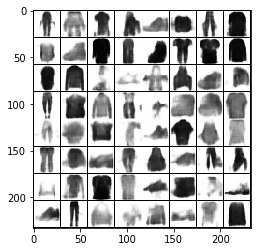

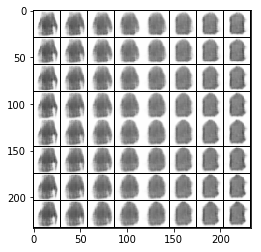

In [5]:
with open(args.file, 'rb') as file:
    vae = pickle.load(file)

vae.eval()
with torch.no_grad():
    samples = utils.make_grid(1 - vae.decode(z_random), padding=1)
    plt.imshow(samples.numpy().transpose([1, 2, 0]))
    plt.show()

    interps = utils.make_grid(1 - vae.decode(z_interp), padding=1)
    plt.imshow(interps.numpy().transpose([1, 2, 0]))
    plt.show()
